## Advanced Modelling of the Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
use_gpu=True

In [3]:
if use_gpu:
    import cudf as dd
    from cuml.preprocessing.model_selection import train_test_split
    from cuml.metrics import confusion_matrix, roc_auc_score
else:
    import pandas as dd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, roc_auc_score

In [84]:
# first lets reload the dataset
# we do need to import pandas as it is also need for display max_rows 
import pandas as pd
import cudf
import numpy as np
import gc
import cupy
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# to avoid issues due to lack of VRAM
if use_gpu:
    cudf.set_allocator("managed")

## Read in the Features

In [6]:
## testing our previous big feats table
train = dd.read_parquet('data_eng/feats/train_feats.parquet')

## test is the kaggle test set which we only need for submission 
#test = dd.read_parquet('data_eng/feats/test_feats.parquet')
train_target = train['TARGET']
train = train.drop('TARGET', axis =1)

In [7]:
train.shape

(307511, 638)

In [8]:
# we have an unbalanced pos to negative ratio so it will help to feed this into xgb
ratio = (train_target == 0).sum()/ (train_target == 1).sum()
ratio

11.387150050352467

## Cross Validating our XGB Model

Default train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, train_target, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [10]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

We use stratified KFold as the classes are heavily unbalanced. Stratified KFold makes sure that we have a same proportion of target variables (0/1) in each kfold split 

In [11]:
skf = StratifiedKFold()

In [12]:
cv_params = {'tree_method': 'gpu_hist', 'max_depth': 6, 
             'learning_rate': 0.05, 'subsample':0.5, 
             'objective': 'binary:logistic',
             'eval_metric':'auc', 'scale_pos_weight': ratio,
             'gamma':0.3, 'subsample':0.5}

We use stratified KFold to check and see if different splits of the data produce consistant results. This is important to make sure we aren't overfitting to a particular subset of data

In [13]:
for i, (train_index, test_index) in enumerate(skf.split(X_train.index.to_arrow().tolist(), 
                                                        y_train.to_arrow().tolist())):
    print("Fold {0}".format(i))
    X_train_kf, X_valid_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_valid_kf = y_train.iloc[train_index], y_train.iloc[test_index]
    
    train_matrix_kf= xgb.DMatrix(X_train_kf, label=y_train_kf)
    val_matrix_kf = xgb.DMatrix(X_valid_kf, label=y_valid_kf)
    
    bst = xgb.train(params=cv_params, dtrain=train_matrix_kf, 
                evals=[(train_matrix_kf, 'train'), (val_matrix_kf, 'valid')], 
                num_boost_round=100, early_stopping_rounds=20, verbose_eval=20)

Fold 0
[0]	train-auc:0.73321	valid-auc:0.71745
[20]	train-auc:0.77740	valid-auc:0.75342
[40]	train-auc:0.79448	valid-auc:0.76197
[60]	train-auc:0.80838	valid-auc:0.76900
[80]	train-auc:0.81995	valid-auc:0.77272
[99]	train-auc:0.82852	valid-auc:0.77489
Fold 1
[0]	train-auc:0.73559	valid-auc:0.70825
[20]	train-auc:0.77842	valid-auc:0.74388
[40]	train-auc:0.79482	valid-auc:0.75355
[60]	train-auc:0.80983	valid-auc:0.76029
[80]	train-auc:0.82071	valid-auc:0.76386
[99]	train-auc:0.82961	valid-auc:0.76641
Fold 2
[0]	train-auc:0.73406	valid-auc:0.71950
[20]	train-auc:0.77802	valid-auc:0.75499
[40]	train-auc:0.79453	valid-auc:0.76350
[60]	train-auc:0.80849	valid-auc:0.77025
[80]	train-auc:0.81937	valid-auc:0.77492
[99]	train-auc:0.82800	valid-auc:0.77774
Fold 3
[0]	train-auc:0.73394	valid-auc:0.71491
[20]	train-auc:0.77867	valid-auc:0.75626
[40]	train-auc:0.79454	valid-auc:0.76432
[60]	train-auc:0.80924	valid-auc:0.77047
[80]	train-auc:0.81986	valid-auc:0.77462
[99]	train-auc:0.82855	valid-auc:

In [22]:
del X_train_kf, X_valid_kf
gc.collect()

17

In [21]:
del bst, train_matrix_kf, val_matrix_kf
gc.collect()

113

Once things look a bit stable with the tuning, we will train our "final" model on the full dataset

In [14]:
full_cv_params =  cv_params
# a common technique is to set learning rate lower and 
# boost the num_boost_rounds for the full train
full_cv_params['learning_rate'] = cv_params['learning_rate']/10

In [15]:
train_matrix = xgb.DMatrix(X_train, label=y_train)
val_matrix = xgb.DMatrix(X_test, label=y_test)
    
final_bst = xgb.train(params=full_cv_params, dtrain=train_matrix, 
                evals=[(train_matrix, 'train'), (val_matrix, 'valid')], 
                num_boost_round=1000, early_stopping_rounds=20, 
                verbose_eval=50)

[0]	train-auc:0.73264	valid-auc:0.71409
[50]	train-auc:0.76342	valid-auc:0.74143
[100]	train-auc:0.76780	valid-auc:0.74401
[150]	train-auc:0.77172	valid-auc:0.74643
[200]	train-auc:0.77549	valid-auc:0.74850
[250]	train-auc:0.77932	valid-auc:0.75078
[300]	train-auc:0.78314	valid-auc:0.75308
[350]	train-auc:0.78689	valid-auc:0.75513
[400]	train-auc:0.79072	valid-auc:0.75737
[450]	train-auc:0.79462	valid-auc:0.75957
[500]	train-auc:0.79835	valid-auc:0.76154
[550]	train-auc:0.80182	valid-auc:0.76344
[600]	train-auc:0.80472	valid-auc:0.76488
[650]	train-auc:0.80756	valid-auc:0.76630
[700]	train-auc:0.81034	valid-auc:0.76763
[750]	train-auc:0.81303	valid-auc:0.76885
[800]	train-auc:0.81551	valid-auc:0.76992
[850]	train-auc:0.81787	valid-auc:0.77085
[900]	train-auc:0.82010	valid-auc:0.77179
[950]	train-auc:0.82211	valid-auc:0.77252
[999]	train-auc:0.82410	valid-auc:0.77329


In [16]:
adv_y_pred = final_bst.predict(val_matrix)
# convert to 0/1 based on threshold
adv_y_final = np.where(adv_y_pred>0.5, 1, 0)

# Final Assessments

In [17]:
confusion_matrix(y_test, adv_y_final.astype('Int64'))

<ipython-input-17-3f2062bd99d2>:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  confusion_matrix(y_test, adv_y_final.astype('Int64'))


,0,1
0,62376,22395
1,2457,5025


In [18]:
roc_auc_score(y_test, adv_y_pred)

0.7732909321784973

## Evaluating Feature Importances

Evaluating the importance of features using SHAP values

In [19]:
final_bst.set_param({"predictor": "gpu_predictor"})
shap_values = final_bst.predict(val_matrix, pred_contribs=True)

In [48]:
shap_values.shape

(92253, 638)

In [86]:
type(cupy.asnumpy(X_test.iloc[0].values))

numpy.ndarray

In [74]:
# We can use the shap package
import shap

# shap will call the GPU accelerated version as long as the predictor 
# parameter is set to "gpu_predictor"
final_bst.set_param({"predictor": "gpu_predictor"})
explainer = shap.TreeExplainer(final_bst)
shap_values = explainer.shap_values(X_test)

In [96]:
row=0

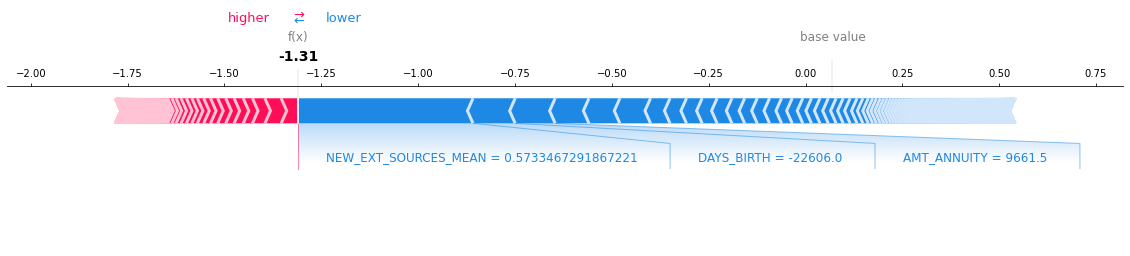

In [97]:
# visualize the first prediction's explanation
shap.force_plot(
    explainer.expected_value,
    shap_values[row, :],
    cupy.asnumpy(X_test.iloc[row].values),
    feature_names=X_test.columns.to_list(),
    matplotlib=True
)

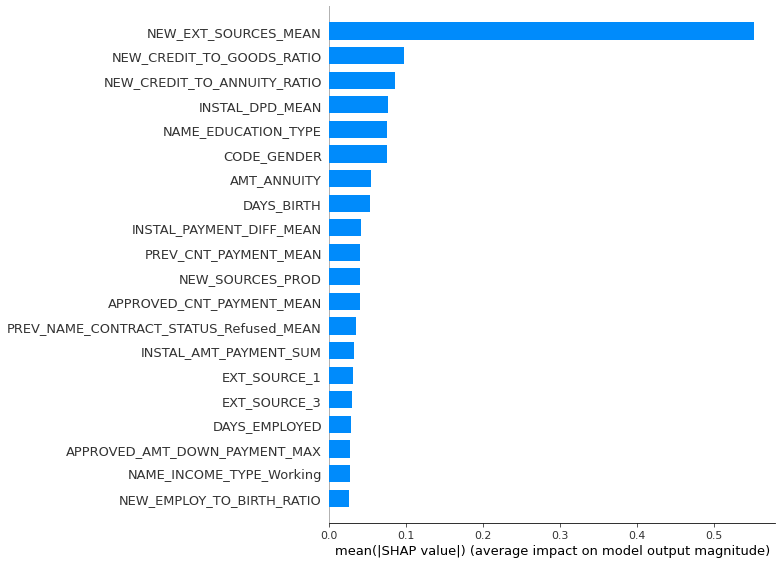

In [31]:
# Show a summary of feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar", 
                  feature_names=X_test.columns)

In [66]:
# quick test
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data.data
y = data.target
